In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def overlaping_area(detection_1,detection_2):
    #detection_1,detection_2 format [x_left_top,y_left_top,score,width,height]
    x_1 = detection_1[0]
    y_1 = detection_1[1]
    x_w_1 = detection_1[0] + detection_1[3]
    y_h_1 = detection_1[1] + detection_1[4]
    
    x_2 = detection_2[0]
    y_2 = detection_2[1]
    x_w_2 = detection_2[0] + detection_2[3]
    y_h_2 = detection_2[1] + detection_2[4]
    # tính overlap theo ox,oy .Nếu ko giao nhau trả về 0
    overlap_x = max(0,min(x_w_1,x_w_2) - max(x_1,x_2))
    overlap_y = max(0,min(y_h_1,y_h_2) - max(y_1,y_2))
    # tính area overlap
    overlap_area = overlap_x*overlap_y
    # tính total area hợp của 2 detection
    total_area = detection_1[3]*detection_1[4] + detection_2[3]*detection_2[4] - overlap_area
    
    return overlap_area/float(total_area)
    

In [5]:
overlaping_area([31, 31, 10, 10, 10], [31, 31, .10, 10, 10])

1.0

In [7]:
def nms(detections,threshold =0.4):
    # decections format [x_left_top,y_left_top,score,width,height]
    # nếu area overlap lớn hơn threshold thì sẽ remove detection nào có score nhỏ hơn
    if len(detections)==0:
        return []
    # sort detection theo score
    detections = sorted(detections,key = lambda detections : detections[2],reverse = True)
    #create new detection
    new_detections = []
    new_detections.append(detections[0])
    del detections[0]
    for index,detection in enumerate(detections):
        for new_detection in new_detections:
            if overlaping_area(detection,new_detection)> threshold : #compare areaoverlap với threshold
                del detections[index]
                break
        else :
            new_detections.append(detection)
            del detections[index]
    return new_detections

In [8]:
detections = [[31, 31, .9, 10, 10], [31, 31, .12, 10, 10], [100, 34, .8,10, 10]]

In [9]:
nms(detections)

[[31, 31, 0.9, 10, 10], [100, 34, 0.8, 10, 10]]

In [10]:
from skimage.transform import pyramid_gaussian
from skimage import io
from skimage.feature import hog
import glob

In [36]:
def hog_feature(image):
    feature_hog = hog(image,orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm="L2")
    return feature_hog

In [37]:
len(path_neg)

50

(128, 64, 3)

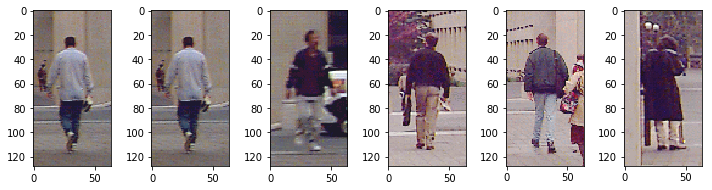

In [38]:
path_pos = glob.glob("./pedestrians128x64/"+"*.ppm")
plt.subplots(figsize =(10,5))
for i in range(6):
    image1 = io.imread(path_pos[i])
    plt.subplot(1,6,i +1)
    io.imshow(image1)
image1.shape

In [39]:
X_pos = []
y_pos = []
for path in path_pos :
    im = io.imread(path,as_grey=True)
    im_feature = hog_feature(im)
    X_pos.append(im_feature)
    y_pos.append(1)

In [40]:
path_neg = glob.glob("./pedestrians_neg/"+"*.jpg")

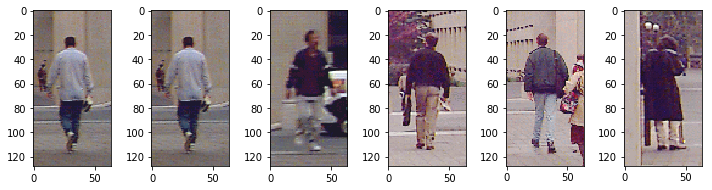

In [41]:
plt.subplots(figsize =(10,5))
for i in range(6):
    image1 = io.imread(path_pos[i])
    plt.subplot(1,6,i +1)
    io.imshow(image1)

In [42]:
X_neg = []
y_neg = []
w = 64
h = 128
for path in path_neg :
    im = io.imread(path,as_grey=True)
    for j in range(15):
        x = np.random.randint(0,im.shape[1]-w)
        y = np.random.randint(0,im.shape[0]-h)
        im_crop = im[y:y+h,x:x+w]
        im_feature = hog_feature(im_crop)
        X_neg.append(im_feature)
        y_neg.append(-1)

In [58]:
X_pos = np.array(X_pos)
X_neg = np.array(X_neg)
X_train = np.concatenate((X_pos,X_neg))
y_pos = np.array(y_pos)
y_neg = np.array(y_neg)
y_train = np.concatenate((y_pos,y_neg))

In [59]:
#from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3,random_state=10)

In [60]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [61]:
model = LinearSVC(C=0.01)
model.fit(X_train,y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [62]:
y_predict = model.predict(X_train)

In [63]:
print(classification_report(y_train,y_predict))

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00       750
          1       1.00      1.00      1.00       924

avg / total       1.00      1.00      1.00      1674



In [70]:
thre = model.decision_function(X_test)
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(model, X_train, y_train, cv=3,
                             method="decision_function")[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

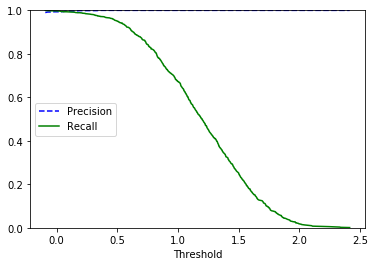

In [71]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [79]:
thre = model.decision_function(X_train)
np.sum(thr>1)

707

In [80]:
def sliding_window(image,window_size,step_size):
    for y in range(0,image.shape[0]-window_size[1],step_size[1]):
        for x in range(0,image.shape[1]-window_size[0],step_size[0]):
            roi = image[y:y+window_size[1],x:x+window_size[0]]
            yield (x,y,roi)
        

(480, 640)


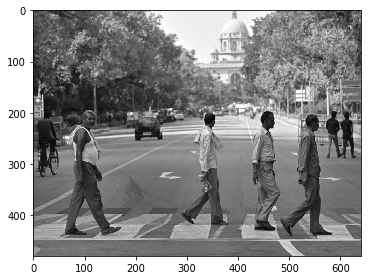

In [287]:
image = cv2.imread("pedestrian1.jpg")
image1 = image.copy()
image_test = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
io.imshow(image_test)
print(image_test.shape)

In [291]:
window_size = (64,128)
step_size = (10,10)
detections = []
downscale=1.5
scale = 0
for image_scale in pyramid_gaussian(image_test,downscale=2):
    scale += 1
    if image_scale.shape[0] < window_size[1] or image_scale.shape[1] < window_size[0]:
        break
    for (x,y,roi) in sliding_window(image_scale,window_size,step_size):
        feature = hog_feature(roi)
        predict = model.predict(feature.reshape((-1,3780)))
        score = model.decision_function(feature.reshape((-1,3780)))
        if (predict == 1) and (score>0.4):
            detections.append([x,y,np.round(score,4),window_size[0],window_size[1]])

In [292]:
detections

[[430, 160, array([ 0.675]), 64, 128],
 [400, 180, array([ 0.6174]), 64, 128],
 [60, 190, array([ 0.4673]), 64, 128],
 [60, 200, array([ 0.946]), 64, 128],
 [300, 200, array([ 0.4308]), 64, 128],
 [500, 200, array([ 0.536]), 64, 128]]

window_size = (64,128)
step_size = (20,20)
detections = []
for (x,y,roi) in sliding_window(image_test,window_size,step_size):
    feature = hog_feature(roi)
    predict = model.predict(feature.reshape((-1,3780)))
    score = model.decision_function(feature.reshape((-1,3780)))
    if (predict == 1) and (score>0.5):
        detections.append((x,y,np.round(score,4),64,128))

In [293]:
detections = nms(detections,0.5)
for (x,y,_,w,h) in detections :
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),3)
cv2.imshow("roi",image)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.imwrite("out2.jpg",image)

True

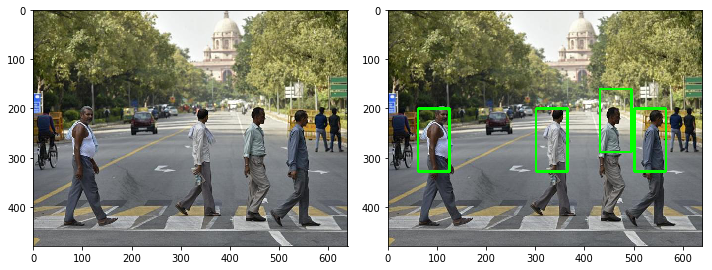

In [294]:
plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
io.imshow(cv2.cvtColor(image1,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
io.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))